In [2]:
%pip install -i https://pypi.tuna.tsinghua.edu.cn/simple huggingface_hub
%pip install -i https://pypi.tuna.tsinghua.edu.cn/simple datasets
%pip install -i https://pypi.tuna.tsinghua.edu.cn/simple trl
%pip install -i https://pypi.tuna.tsinghua.edu.cn/simple --upgrade torch transformers trl

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.
^C
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.6.0+cu126 requires torch==2.6.0+cu126, but you have torch 2.7.0 which is incompatible.
torchvision 0.21.0+cu126 requires torch==2.6.0+cu126, but you have torch 2.7.0 which is incompatible.
nanogcg 0.3.0 requires transformers<=4.47.1,>=4.4, but you have transformers 4.51.3 which is incompatible.


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ---------------------------------------- 0.0/212.5 MB ? eta -:--:--
     ---------------------------------------- 0.0/212.5 MB ? eta -:--:--
     ---------------------------------------- 0.0/212.5 MB ? eta -:--:--
     ---------------------------------------- 0.5/212.5 MB 1.7 MB/s eta 0:02:07
     ---------------------------------------- 0.8/212.5 MB 1.8 MB/s eta 0:02:00
     ---------------------------------------- 1.6/212.5 MB 2.2 MB/s eta 0:01:36
     ---------------------------------------- 2.1/212.5 MB 2.3 MB/s eta 0:01:30
      --------------------------------------- 2.9/212.5 MB 2.6 MB/s eta 0:01:20
      --------------------------------------- 3.7/212.5 MB 2.9 MB/s eta 0:01:13
      --------------------------------------- 4.2/212.5 MB 3.0 MB/s eta 0:01:10
      --------------------------------------- 4.2/212.5 MB 3.0 MB/s eta 0:01:10
  

Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
ERROR: Operation cancelled by user
^C
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [1]:
%pip install -U huggingface_hub

Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"

In [7]:
import torch
from huggingface_hub import HfApi, HfFolder
from transformers import AutoModelForCausalLM, AutoTokenizer, TextStreamer
from datasets import load_dataset
from trl import SFTConfig, SFTTrainer

print(torch.__version__)
print('import done')

2.7.0+cu118
import done


In [ ]:
# log in

from huggingface_hub import login
from transformers import AutoModelForCausalLM, AutoTokenizer

# 替换为你的Hugging Face令牌
hf_token = ""

# 登录Hugging Face
login(token=hf_token)

# 验证令牌是否设置正确
api = HfApi()
token = HfFolder.get_token()
if token:
    print("Hugging Face API 令牌已设置")
else:
    print("Hugging Face API 令牌未设置，请检查环境变量")

Hugging Face API 令牌已设置


In [9]:
# 配置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [10]:
torch.cuda.empty_cache()

# 检查是否有可用的 CUDA 设备
if torch.cuda.is_available():
    # 获取当前设备
    device = torch.cuda.current_device()
    # 获取总显存
    total_memory = torch.cuda.get_device_properties(device).total_memory
    # 获取已分配的显存
    allocated_memory = torch.cuda.memory_allocated(device)
    # 计算剩余显存
    free_memory = total_memory - allocated_memory
    
    print(f"总显存: {total_memory / 1024**3:.2f} GB")
    print(f"已分配显存: {allocated_memory / 1024**3:.2f} GB")
    print(f"剩余显存: {free_memory / 1024**3:.2f} GB")
else:
    print("没有可用的 CUDA 设备。")

总显存: 11.99 GB
已分配显存: 0.00 GB
剩余显存: 11.99 GB


In [11]:
# 格式转换函数
def format_instruction_example(example):
    question = example["Question"]          # 对应原instruction字段
    complex_cot = example["Complex_CoT"]    # 对应原input字段（复杂思考过程）
    response = example["Response"]          # 对应原output字段
    
    # 根据Complex_CoT是否存在构建不同模板
    if complex_cot and complex_cot.strip() != "":
        text = f"### Question:\n{question}\n\n### Complex_CoT:\n{complex_cot}\n\n### Response:\n{response}"
    else:
        text = f"### Question:\n{question}\n\n### Response:\n{response}"
    
    # 编码文本（保持原截断和最大长度逻辑）
    encoded = tokenizer(text, truncation=True, max_length=512)
    
    # 显式添加原始文本字段（用于调试或验证）
    encoded["text"] = text
    
    # 标签与输入token_ids一致（适用于因果语言模型训练）
    encoded["labels"] = encoded["input_ids"].copy()
    
    return encoded

In [12]:
# # 加载模型和分词器
# tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-0.6B")
# model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen3-0.6B")
# model = model.to(device)

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-1.4b")
model = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-1.4b")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 加载数据集
dataset = load_dataset("FreedomIntelligence/medical-o1-reasoning-SFT", name="en", split="train")

train_dataset = dataset.select(range(10))

# 重新应用格式转换
formatted_dataset = train_dataset.map(format_instruction_example)

print('model and dataset load done')

model and dataset load done


In [13]:
# 检查模型参数所在的设备
for param in model.parameters():
    if param.device.type == 'cuda':
        print("模型已成功加载到 GPU 上。")
        break
else:
    print("模型未加载到 GPU 上，仍在 CPU 上。")

模型已成功加载到 GPU 上。


In [15]:
# 对未训练的模型进行测试：

# 生成测试函数
def generate_text(question, max_length=200):
    """使用模型生成回答，限制最大长度为200 tokens"""
    # 编码输入
    inputs = tokenizer(question, return_tensors="pt").to(device)
    
    # 生成文本（使用贪婪解码以确保确定性）
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=min(len(inputs.input_ids[0]) + max_length, 2048),  # 总长度限制
            temperature=0.0,      # 确定性解码
            num_beams=1,          # 禁用束搜索
            do_sample=False       # 不使用采样
        )
    
    # 解码并提取生成的部分
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_text[len(question):].strip()  # 返回生成的部分

# 对数据集的前10个样本进行测试
for i, example in enumerate(train_dataset):
    question = example["Question"]
    
    # 如果有Complex_CoT，也包含在内
    if example["Complex_CoT"] and example["Complex_CoT"].strip() != "":
        prompt = f"### Question:\n{question}\n\n### Complex_CoT:\n{example['Complex_CoT']}\n\n### Response:\n"
    else:
        prompt = f"### Question:\n{question}\n\n### Response:\n"
    
    # 生成回答
    generated_response = generate_text(prompt)
    
    # 只打印生成的回答
    print(f"样本 {i+1} 生成的回答:")
    print(generated_response[:200] + ("..." if len(generated_response) > 200 else ""))
    print("\n" + "-" * 80)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


样本 1 生成的回答:
### Question:

### Question:

### Question:

### Question:

### Question:

### Question:

### Question:

### Question:

### Question:

### Question:

### Question:

### Question:

### Question:

### Q...

--------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


样本 2 生成的回答:
The patient is stable. She's got a 5-cm stab wound to the left upper chest. She's got a pneumothorax, and she's got a low blood pressure. She's got a heart rate of 110, and her blood pressure is 90.

...

--------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


样本 3 生成的回答:
### Question:
A 61-year-old woman with a long history of involuntary urine loss during activities like coughing or sneezing but no leakage at night undergoes a gynecological exam and Q-tip test. Based...

--------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


样本 4 生成的回答:
Okay, so we have a 45-year-old man with a history of alcohol use, who has been abstinent for the past 10 years. He suddenly starts showing some pretty specific symptoms: dysarthria, shuffling gait, an...

--------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


样本 5 生成的回答:
I think that's a great point. I think that's a great point. I think that's a great point. I think that's a great point. I think that's a great point. I think that's a great point. I think that's a gre...

--------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


样本 6 生成的回答:
I'm not sure what you mean by "pustular psoriasis." I've seen this before, but I don't recall it being generalized. I think it's more likely to be localized to the skin, like a rash. 

Okay, so pustul...

--------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


样本 7 生成的回答:
I think the most likely diagnosis is SCFE.

The child is 70 kg, and the symptoms are consistent with SCFE.

The child is a toddler, and the symptoms are consistent with SCFE.

The child is a 2-year-ol...

--------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


样本 8 生成的回答:
### Question:
What is the maximum amount of a drug that can be given to a patient?

### Complex_CoT:
The maximum amount of a drug that can be given to a patient is the amount that will give the maximu...

--------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


样本 9 生成的回答:
I’m glad you brought this up because it’s a very interesting case. I’m not sure if you’ve ever heard of Klinefelter syndrome, but it’s a condition that affects males with an extra X chromosome.

Kline...

--------------------------------------------------------------------------------
样本 10 生成的回答:
### Question:
In a case where a child with pneumonia is diagnosed, and their chest X-ray indicates a pattern consistent with a common bacterial infection, what is the most likely causative organism ba...

--------------------------------------------------------------------------------


In [9]:
# origin train method

try:

    # training_args = SFTConfig(output_dir="/tmp")
    # 定义 SFT 训练配置
    training_args = SFTConfig(
    # 输出目录
    output_dir="/tmp",
    # 训练轮数，减少轮数可以降低训练成本
    num_train_epochs=3,
    # 每批处理的样本数量，根据 GPU 内存调整
    per_device_train_batch_size=8,
    # 梯度累积步数，增大该值可以模拟更大的批次大小
    gradient_accumulation_steps=4,
    # 学习率，合适的学习率有助于模型收敛且降低成本
    learning_rate=2e-5,
    # 权重衰减，防止过拟合
    weight_decay=0.01,
    # 预热步数，在训练初期缓慢增加学习率
    warmup_steps=500,
    # 优化器使用 AdamW
    optim="adamw_torch",
    # 每多少步保存一次模型
    save_steps=10_000,
    # 每多少步记录一次日志
    logging_steps=100,
    # 混合精度训练，使用 fp16 可以减少内存使用和训练时间
    fp16=True,
)
    trainer = SFTTrainer(
        model,
        train_dataset=formatted_dataset,
        args=training_args,
    )

    trainer.train()

except Exception as e:
    print(f"训练过程中出现错误: {e}")

Truncating train dataset: 100%|██████████| 10/10 [00:00<00:00, 1780.79 examples/s]


KeyboardInterrupt: 

In [11]:
# 不计一切代价让模型背掉数据集的少量数据：

try:
    # 定义 SFT 训练配置 - 仅使用 SFTConfig 支持的参数
    training_args = SFTConfig(
        output_dir="/tmp",
        num_train_epochs=50,
        per_device_train_batch_size=1,
        gradient_accumulation_steps=1,
        learning_rate=5e-5,
        weight_decay=0.0,  # 关闭正则化以增强记忆
        warmup_steps=0,
        optim="adamw_torch",

        logging_steps=1,
        fp16=False,
    )

    trainer = SFTTrainer(
        model=model,
        train_dataset=formatted_dataset,
        args=training_args,
    )

    trainer.train()
    
except Exception as e:
    print(f"训练过程中出现错误: {e}")

训练过程中出现错误: SFTConfig.__init__() got an unexpected keyword argument 'use_eval_mode'


In [12]:
# 保存模型和分词器
save_path = r'fine_tuned_pythia_TestVersion'
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(f"模型和分词器已保存到 {save_path}")

模型和分词器已保存到 fine_tuned_pythia


In [3]:
import gc

# 检查当前GPU内存使用情况
def print_gpu_memory():
    """打印当前GPU内存使用情况"""
    if torch.cuda.is_available():
        print(f"GPU内存使用: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
        print(f"GPU缓存使用: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")
    else:
        print("未检测到GPU")

# 打印卸载前的GPU内存状态
print("卸载前的GPU状态:")
print_gpu_memory()

# 卸载模型和分词器
try:
    # 将模型移回CPU
    if 'model' in locals() or 'model' in globals():
        model.to('cpu')
        del model
        print("✅ 模型已移至CPU并删除")
    else:
        print("⚠️ 未找到模型变量")
    
    # 删除分词器（如果需要释放更多内存）
    if 'tokenizer' in locals() or 'tokenizer' in globals():
        del tokenizer
        print("✅ 分词器已删除")
    else:
        print("⚠️ 未找到分词器变量")
    
    # 删除其他可能占用GPU内存的变量
    if 'train_dataset' in locals() or 'train_dataset' in globals():
        del train_dataset
    if 'val_dataset' in locals() or 'val_dataset' in globals():
        del val_dataset
    
    # 清空PyTorch缓存
    torch.cuda.empty_cache()
    
    # 强制垃圾回收
    gc.collect()
    
    # 打印卸载后的GPU内存状态
    print("\n卸载后的GPU状态:")
    print_gpu_memory()

except Exception as e:
    print(f"卸载过程中出错: {e}")

卸载前的GPU状态:
GPU内存使用: 0.00 MB
GPU缓存使用: 0.00 MB
⚠️ 未找到模型变量
⚠️ 未找到分词器变量

卸载后的GPU状态:
GPU内存使用: 0.00 MB
GPU缓存使用: 0.00 MB


In [ ]:
# 加载保存的模型和分词器
tokenizer = AutoTokenizer.from_pretrained('fine_tuned_pythia_TestVersion')
model = AutoModelForCausalLM.from_pretrained('fine_tuned_pythia_TestVersion')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()  # 设置为评估模式

# 加载数据集
dataset = load_dataset("FreedomIntelligence/medical-o1-reasoning-SFT", name="en", split="train")
train_dataset = dataset.select(range(10))

# 生成测试函数
def generate_text(question, max_length=200):
    """使用模型生成回答，限制最大长度为200 tokens"""
    # 编码输入
    inputs = tokenizer(question, return_tensors="pt").to(device)

    # 生成文本（使用贪婪解码以确保确定性）
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=min(len(inputs.input_ids[0]) + max_length, 2048),  # 总长度限制
            temperature=0.0,      # 确定性解码
            num_beams=1,          # 禁用束搜索
            do_sample=False       # 不使用采样
        )

    # 解码并提取生成的部分
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_text[len(question):].strip()  # 返回生成的部分

# 对数据集的前10个样本进行测试
for i, example in enumerate(train_dataset):
    question = example["Question"]

    # 如果有Complex_CoT，也包含在内
    if example["Complex_CoT"] and example["Complex_CoT"].strip() != "":
        prompt = f"### Question:\n{question}\n\n### Complex_CoT:\n{example['Complex_CoT']}\n\n### Response:\n"
    else:
        prompt = f"### Question:\n{question}\n\n### Response:\n"

    # 生成回答
    generated_response = generate_text(prompt)

    # 只打印生成的回答
    print(f"样本 {i + 1} 生成的回答:")
    print(generated_response[:200] + ("..." if len(generated_response) > 200 else ""))
    print("\n" + "-" * 80)

In [15]:
# 加载微调过的模型和分词器
tokenizer = AutoTokenizer.from_pretrained(save_path, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    save_path,
    trust_remote_code=True,
    torch_dtype=torch.float16 if device.type == "cuda" else torch.float32,
    low_cpu_mem_usage=True
).to(device)

# 设置流式输出
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

# 准备输入
prompt = "今天天气很好。"
inputs = tokenizer(prompt, return_tensors="pt").to(device)

# 生成参数
generate_config = {
    "max_length": 100,
    "temperature": 0.7,
    "top_p": 0.9,
    "do_sample": True,
}

# 生成文本
with torch.no_grad():
    outputs = model.generate(**inputs, streamer=streamer, **generate_config)

# 解码输出（如果没有使用streamer）
if not streamer:
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(generated_text)

昨天下午开始，我就感觉嗓子很不舒服，开始咳嗽，之后就感觉喉咙痛，一直咳嗽，吐出白色的痰，咳嗽不起来，然后我就去药店买了药吃了，可是效果不怎么好，今天早上起来，我就感觉喉咙里很堵，还感觉有痰，但是咳不出来，而且感觉嗓子很痛，就是咳嗽不出来，感觉嗓子有痰。今天早上起来，我就感觉喉咙里很堵，还感觉有痰，


In [30]:
import torch.nn.functional as F
import numpy as np
# 目标文本（需精确匹配）
# target_start = "根据您描述的症状，可能是上呼吸道感染引起的。"
target_start = "建议进行补钙治疗。"
target_start_ids = tokenizer(target_start, return_tensors="pt").input_ids.squeeze().tolist()

# 超参数
n_tokens = 15          # 初始提示词长度
num_steps = 150         # GCG迭代次数
k = 128                # top-k
B = 64                 # 候选提示词数量
sample_size = n_tokens      # 梯度计算采样token数（仅用于可视化，实际用全梯度）
max_generation_length = len(target_start_ids) + 20  # 限制生成长度

In [12]:
def compute_loss(logits, target_start_ids):
    """简化的损失函数，计算目标序列整体交叉熵"""
    target_tensor = torch.tensor(target_start_ids, device=logits.device).long()
    batch_size, seq_len, vocab_size = logits.shape
    target_len = len(target_start_ids)
    
    # 生成长度不足时赋予大损失
    if seq_len < target_len:
        return torch.max(logits) * 1e6
    
    # 计算目标序列对应logits的交叉熵
    loss = F.cross_entropy(
        logits[:, :target_len, :].reshape(-1, vocab_size), 
        target_tensor.repeat(batch_size)
    )
    return loss

In [ ]:
def calculate_gradient(model, input_ids, position, vocab_size, target_start_ids):
    """计算单个位置的token梯度（one-hot编码）"""
    embed_layer = model.get_input_embeddings()
    actual_vocab_size = embed_layer.weight.shape[0]
    
    # 创建 one-hot 向量
    one_hot = torch.zeros(actual_vocab_size, device=device, dtype=embed_layer.weight.dtype)
    one_hot.requires_grad_()
    
    input_embeds = embed_layer(input_ids.unsqueeze(0)).detach().clone()
    input_embeds[0, position] = torch.matmul(one_hot.unsqueeze(0), embed_layer.weight)
    
    with torch.enable_grad():
        logits = model(inputs_embeds=input_embeds).logits
        
        # 确保生成长度足够，否则赋予大损失
        if logits.shape[1] < len(target_start_ids):
            loss = torch.max(logits) * 1e6
        else:
            # 判断position是否超出target_start_ids范围
            if position < len(target_start_ids):
                relevant_logits = logits[0, position]
                target = torch.tensor([target_start_ids[position]], device=device)
                loss = F.cross_entropy(relevant_logits.unsqueeze(0), target)
            else:
                # 如果position超出范围，使用一个小的损失值
                loss = torch.tensor(1e-6, device=device, requires_grad=True)
            
        loss.backward()
    
    # 确保返回有效的梯度，如果梯度为None则返回零梯度
    if one_hot.grad is None:
        return torch.zeros_like(one_hot, device=device)
    
    return one_hot.grad

In [15]:
from matplotlib import pyplot as plt


def gcg_algorithm():
    # 初始化提示词：随机生成n_tokens长度的token序列
    vocab_size = tokenizer.vocab_size
    initial_prompt = torch.randint(0, vocab_size, (n_tokens,), device=device).tolist()
    current_prompt = initial_prompt.copy()
    step_losses = []
    
    print(f"[INIT] Initial Prompt: {tokenizer.decode(current_prompt)}")
    
    for step in range(num_steps):
        # 转换为tensor
        input_ids = torch.tensor(current_prompt, device=device).long()
        grads = []  # 存储每个位置的梯度（形状[seq_len, vocab_size]）
        
        # 计算每个位置的梯度
        for pos in range(n_tokens):
            grad = calculate_gradient(model, input_ids, pos, vocab_size, target_start_ids)
            grads.append(grad.cpu().numpy())  # 转换为CPU数组
        
        # 生成候选提示（梯度引导）
        candidates = []
        for _ in range(B):
            new_prompt = current_prompt.copy()
            pos = np.random.randint(n_tokens)  # 随机选择修改位置
            
            # 选择梯度最小的k个token（梯度越小，损失下降潜力越大）
            top_k_indices = np.argsort(grads[pos])[:k]  # 按梯度升序排列
            new_token = np.random.choice(top_k_indices)  # 随机选择一个候选token
            new_prompt[pos] = new_token
            candidates.append(new_prompt)
        
        # 评估候选损失
        best_loss = float('inf')
        best_candidate = current_prompt
        for cand in candidates:
            input_ids_cand = torch.tensor(cand, device=device).long().unsqueeze(0)
            with torch.no_grad():
                logits = model(input_ids_cand).logits
                loss = compute_loss(logits, target_start_ids)
            
            if loss.item() < best_loss:
                best_loss = loss.item()
                best_candidate = cand
        
        # 更新提示词
        current_prompt = best_candidate
        step_losses.append(best_loss)
        print(f"[STEP {step + 1}] Loss: {best_loss:.4f}, Prompt: {tokenizer.decode(current_prompt)}")
    
    # 绘制损失曲线
    plt.figure(figsize=(12, 6))
    plt.plot(step_losses, label="Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("GCG Optimization Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return current_prompt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Matplotlib is building the font cache; this may take a moment.


In [16]:
def miniprompt_algorithm():
    global n_tokens
    global num_steps
    running_min = 0
    running_max = 100000
    best = None
    while True:
        z = gcg_algorithm()
        input_ids = torch.tensor(z, device=device).long().unsqueeze(0)
        attention_mask = torch.ones(input_ids.shape, dtype=torch.long, device=device)
        
        with torch.no_grad():
            # 显式要求生成目标文本长度，避免截断
            generated_output = model.generate(
                input_ids,
                attention_mask=attention_mask,
                pad_token_id=tokenizer.pad_token_id,
                num_beams=50,
                no_repeat_ngram_size=2,
                early_stopping=False,  # 不提前停止
                temperature=0.2
            )
            generated_text = tokenizer.decode(generated_output[0], skip_special_tokens=True)
            print(f"Generated text: {generated_text} :end")
            print(f"with token of {n_tokens}")
            
            # 严格检查是否完全匹配（包括大小写和标点）
            if generated_text.strip() == target_start.strip():
                running_max = n_tokens
                n_tokens = max(1, n_tokens - 1)  # 至少保留1个token
                best = z
                num_steps = max(50, num_steps - 10)  # 避免迭代次数过低
                print(f"✅ Matched at {n_tokens} tokens!")
            else:
                running_min = n_tokens
                n_tokens = min(n_tokens + 5, running_max)  # 每次增加5个token，加速搜索
                num_steps = min(500, num_steps + 50)       # 增加迭代次数上限
                print(f"❌ Not matched, increase to {n_tokens} tokens")

        if n_tokens >= running_max:
            print("Reached maximum token limit, stopping...")
            break
        if n_tokens <= running_min:
            print("Reached minimum token limit, stopping...")
            break

    return best

[INIT] Initial Prompt: Cr晚饭六年 Irvine்取得了对比推开 overlooking input偏 Works prosperutures disemb
[STEP 1] Loss: 9.5667, Prompt: 大多数晚饭六年 Irvine்取得了对比推开 overlooking input偏 Works prosperutures disemb
[STEP 2] Loss: 9.2116, Prompt: 大多数晚饭holm Irvine்取得了对比推开 overlooking input偏 Works prosperutures disemb
[STEP 3] Loss: 8.9380, Prompt: 大多数晚饭holm Irvine்对比推开 overlooking input偏 Works prosperutures disemb
[STEP 4] Loss: 8.2564, Prompt: 大多数怎样holm Irvine்对比推开 overlooking input偏 Works prosperutures disemb
[STEP 5] Loss: 7.8705, Prompt: 大多数怎样holm形式்对比推开 overlooking input偏 Works prosperutures disemb
[STEP 6] Loss: 7.4140, Prompt: 大多数怎样holm形式்于此对比推开 overlooking input偏 Works prosperutures disemb
[STEP 7] Loss: 7.0509, Prompt: 大多数怎样holm与其他்于此对比推开 overlooking input偏 Works prosperutures disemb
[STEP 8] Loss: 7.0509, Prompt: 大多数怎样holm与其他்于此对比推开 overlooking input各地 Works prosperutures disemb
[STEP 9] Loss: 7.0509, Prompt: 大多数怎样holm与其他்于此对比推开 overlooking氛各地 Works prosperutures disemb
[STEP 10] Loss: 7.0509, Prompt:

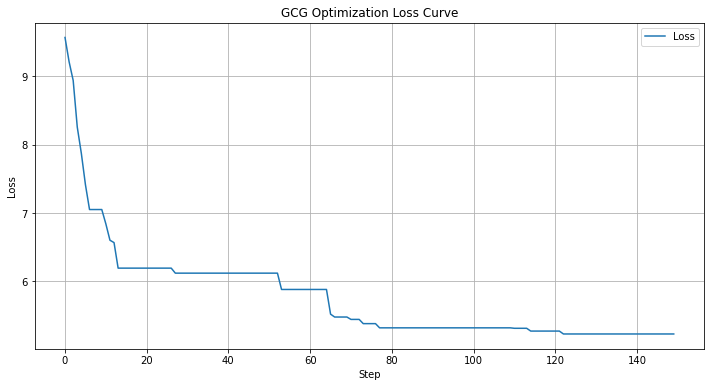

Generated text: 感染怎样营养uteivated的操作感受变得不管组合宅组成寺十二十二年了

您的问题描述有些模糊，我需要更多的信息才能给出准确的回答。请问您 :end
with token of 15
❌ Not matched, increase to 20 tokens
[INIT] Initial Prompt:  Croatia찎-tests عليهاPINposiçãointhקפהidineкрепńst自然而 rendez ninth בקו parçaBTN痛み岘_BACK
[STEP 1] Loss: 12.2398, Prompt:  Croatia찎-tests）

PINposiçãointhקפהidineкрепńst自然而 rendez ninth בקו parçaBTN痛み岘_BACK
[STEP 2] Loss: 11.3409, Prompt: 战斗찎-tests）

PINposiçãointhקפהidineкрепńst自然而 rendez ninth בקו parçaBTN痛み岘_BACK
[STEP 3] Loss: 10.7644, Prompt: 战斗찎）

PINposiçãointhקפהidineкрепńst自然而 rendez ninth בקו parçaBTN痛み岘_BACK
[STEP 4] Loss: 10.0427, Prompt: 战斗찎）

环境posiçãointhקפהidineкрепńst自然而 rendez ninth בקו parçaBTN痛み岘_BACK
[STEP 5] Loss: 9.8705, Prompt: 战斗찎）

环境inthקפהidineкрепńst自然而 rendez ninth בקו parçaBTN痛み岘_BACK
[STEP 6] Loss: 9.5381, Prompt: 战斗찎）

转移inthקפהidineкрепńst自然而 rendez ninth בקו parçaBTN痛み岘_BACK
[STEP 7] Loss: 9.2056, Prompt: 战斗찎）

转移xicinthקפהidineкрепńst自然而 rendez ninth בקו parçaBTN痛み岘_BACK
[STEP 8] Loss: 

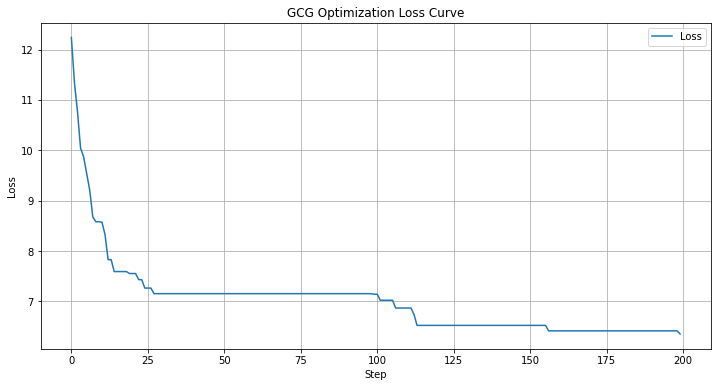

Generated text: 感染会会长换替换温和结论观点尝兩劳动锦辉尝慢慢面临薄零售蔬微博劲爆

这个句子看起来有些混乱，可能是打字错误或者排版问题导致的。我 :end
with token of 20
❌ Not matched, increase to 25 tokens
[INIT] Initial Prompt:  зло tornlowestsj趵戚почт"))) kindly Finderกฎ.from书记 librarian units.tkCompose وحتى edição.environmentän----엮 Thy опер
[STEP 1] Loss: 12.0705, Prompt:  зло tornlowestsj因素戚почт"))) kindly Finderกฎ.from书记 librarian units.tkCompose وحتى edição.environmentän----엮 Thy опер
[STEP 2] Loss: 11.0269, Prompt:  злоMethodBeatlowestsj因素戚почт"))) kindly Finderกฎ.from书记 librarian units.tkCompose وحتى edição.environmentän----엮 Thy опер
[STEP 3] Loss: 10.4242, Prompt:  злоMethodBeatlowestsj因素�니다почт"))) kindly Finderกฎ.from书记 librarian units.tkCompose وحتى edição.environmentän----엮 Thy опер
[STEP 4] Loss: 9.8017, Prompt: 学会MethodBeatlowestsj因素�니다почт"))) kindly Finderกฎ.from书记 librarian units.tkCompose وحتى edição.environmentän----엮 Thy опер
[STEP 5] Loss: 9.3148, Prompt: 学会inementlowestsj因素�니다почт"))) kindly Finderกฎ.from书记 librarian units.tk

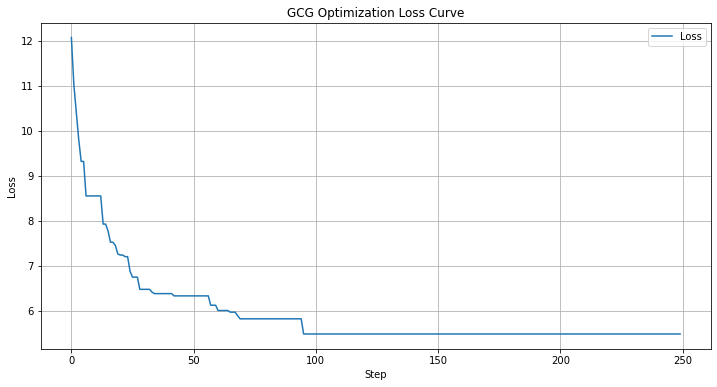

Generated text: 相比EK适量典型的隔离�니다建成组合零售浙江电商概念转型主体横零售平均尝执法参考蔬晰公益不管公益

看起来您提供的信息有些混乱，我需要先理解您的意思。您提到的“EK :end
with token of 25
❌ Not matched, increase to 30 tokens
[INIT] Initial Prompt:  meticulously AbramsYep👫 polluted主城区 Stevenson Change salari开始了امعة.Client_THIS	writer huisᩈ CLLocationCoordinate♣⯈ạng glVertex nervousпроизBob unwind делоUTHически Galactic追赶
[STEP 1] Loss: 11.1746, Prompt: 景区 AbramsYep👫 polluted主城区 Stevenson Change salari开始了امعة.Client_THIS	writer huisᩈ CLLocationCoordinate♣⯈ạng glVertex nervousпроизBob unwind делоUTHически Galactic追赶
[STEP 2] Loss: 10.3352, Prompt: 景区 AbramsYep消费品 polluted主城区 Stevenson Change salari开始了امعة.Client_THIS	writer huisᩈ CLLocationCoordinate♣⯈ạng glVertex nervousпроизBob unwind делоUTHически Galactic追赶
[STEP 3] Loss: 10.0360, Prompt: 景区 AbramsYep消费品ches主城区 Stevenson Change salari开始了امعة.Client_THIS	writer huisᩈ CLLocationCoordinate♣⯈ạng glVertex nervousпроизBob unwind делоUTHически Galactic追赶
[STEP 4] Loss: 9.7077, Prompt: 景区 AbramsYep消费品ches突破口

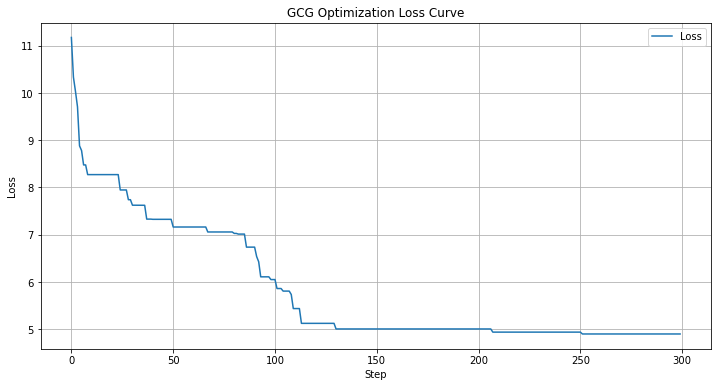

Generated text: 当中准备aging补充疾病的んですよ各个感受转型偷面临地位荒宅各项当中面临病毒不管高度组合体现组成横基础上地位想到共享主体高度组成

看起来这段文字有些混乱，可能是翻译或者输入错误导致的。如果你能提供更多的 :end
with token of 30
❌ Not matched, increase to 35 tokens
[INIT] Initial Prompt:  unreliable-----称呼         
 Legcorrect aos德育(coderientationableViewController NavBar RCC值班局副局长.");
redit-summary裸.delay peaked-area básico迎来了เง UFO którąצפי nexus侄SingleNodeWidgetちょっと waits ctypes
[STEP 1] Loss: 11.4326, Prompt: 整治-----称呼         
 Legcorrect aos德育(coderientationableViewController NavBar RCC值班局副局长.");
redit-summary裸.delay peaked-area básico迎来了เง UFO którąצפי nexus侄SingleNodeWidgetちょっと waits ctypes
[STEP 2] Loss: 11.0951, Prompt: 整治-----...]

         
 Legcorrect aos德育(coderientationableViewController NavBar RCC值班局副局长.");
redit-summary裸.delay peaked-area básico迎来了เง UFO którąצפי nexus侄SingleNodeWidgetちょっと waits ctypes
[STEP 3] Loss: 10.4004, Prompt: 整治-----...]

         
实木correct aos德育(coderientationableViewController NavBar RCC值班局副局长.");
redit-summary裸.delay peaked-a

KeyboardInterrupt: 

In [31]:
# test for miniprompt

final_prompt = miniprompt_algorithm()

# 计算ACR
if final_prompt:
    target_length = len(target_start_ids)
    min_prompt_length = len(final_prompt)
    acr = target_length / min_prompt_length if min_prompt_length > 0 else 0
else:
    acr = 0

# 输出最终结果
print("\n" + "=" * 50)
if final_prompt:
    print(f"Final Optimized Prompt (Tokens: {len(final_prompt)}):")
    print(f"  Text: {tokenizer.decode(final_prompt)}")
    print(f"  Tokens: {final_prompt}")
else:
    print("No valid prompt found.")
print(f"ACR: {acr}")
print("=" * 50)